In [42]:
# General imports
import numpy as np
import torch

# DeepMoD stuff
from multitaskpinn import DeepMoD
from multitaskpinn.model.func_approx import NN
from multitaskpinn.model.library import Library1D
from multitaskpinn.model.constraint import LeastSquares
from multitaskpinn.model.sparse_estimators import Threshold
from multitaskpinn.training import train, train_multitask
from multitaskpinn.training.sparsity_scheduler import TrainTestPeriodic

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from phimal_utilities.data.kdv import DoubleSoliton

if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'
device = 'cpu'

# Settings for reproducibility
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device

'cpu'

# Testing Burgers

In [3]:
# Making dataset
v = 0.1
A = 1.0

x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
dataset = Dataset(BurgersDelta, v=v, A=A)

X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.2, random=True, normalize=False)
X, y = X.to(device), y.to(device)

In [4]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

In [5]:
sparsity_scheduler = TrainTestPeriodic(patience=8, delta=1e-5, periodicity=50)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True, lr=2e-3) # Defining optimizer

In [6]:
train_multitask(model, X, y, optimizer, sparsity_scheduler, write_iterations=25, log_dir='runs/testing_multitask/', max_iterations=15000, delta=1e-3, patience=8) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       2150     14.33%             408s   -1.56e+01   1.40e-03   1.12e-07   1.55e+00 Algorithm converged. Stopping training.


In [7]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

In [8]:
sparsity_scheduler = TrainTestPeriodic(patience=8, delta=1e-5, periodicity=50)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True, lr=2e-3) # Defining optimizer

In [9]:
train(model, X, y, optimizer, sparsity_scheduler, write_iterations=25, log_dir='runs/testing_normal/', max_iterations=15000, delta=1e-3, patience=8) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
      11425     76.17%             111s   1.38e-03   1.36e-03   1.72e-05   1.63e+00 Algorithm converged. Stopping training.


## Quick analysis

In [10]:
from phimal_utilities.analysis import Results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='white')

%config InlineBackend.figure_format = 'svg'

In [11]:
data_mt = Results('runs/testing_multitask/')
data_bl = Results('runs/testing_normal/')

keys = data_mt.keys

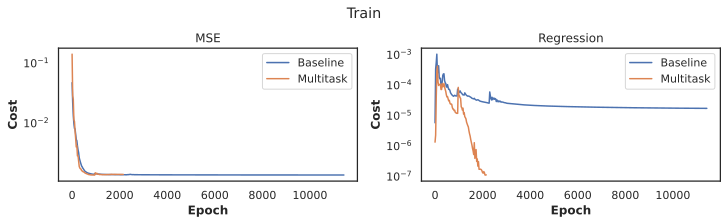

In [26]:
fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, ncols=2)

ax = axes[0]
ax.semilogy(data_bl.df.index, data_bl.df[keys['mse']], label='Baseline')
ax.semilogy(data_mt.df.index, data_mt.df[keys['mse']], label='Multitask')
ax.set_title('MSE')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
ax.legend()
#ax.set_xlim([0, 8000])


ax = axes[1]
ax.semilogy(data_bl.df.index, data_bl.df[keys['reg']], label='Baseline')
ax.semilogy(data_mt.df.index, data_mt.df[keys['reg']], label='Multitask')
ax.set_title('Regression')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
ax.legend()
#ax.set_xlim([0, 8000])

fig.suptitle('Train')
fig.show()

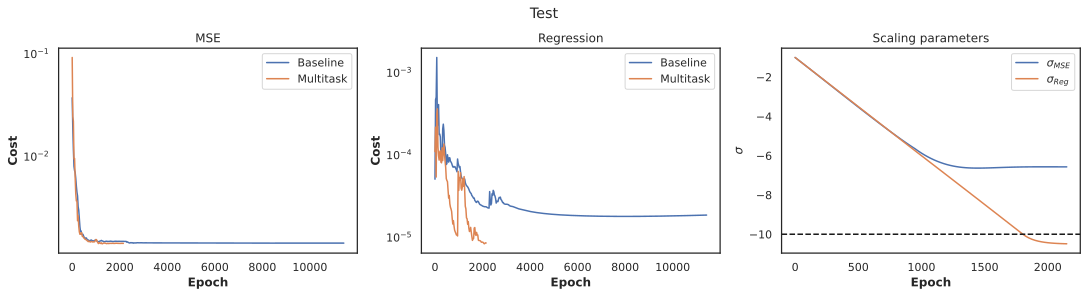

In [41]:
fig, axes = plt.subplots(figsize=(15, 4), constrained_layout=True, ncols=3)

ax = axes[0]
ax.semilogy(data_bl.df.index, data_bl.df['remaining_MSE_test'], label='Baseline')
ax.semilogy(data_mt.df.index, data_mt.df['remaining_MSE_test'], label='Multitask')
ax.set_title('MSE')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
ax.legend()
#ax.set_xlim([0, 8000])


ax = axes[1]
ax.semilogy(data_bl.df.index, data_bl.df['remaining_Reg_test'], label='Baseline')
ax.semilogy(data_mt.df.index, data_mt.df['remaining_Reg_test'], label='Multitask')
ax.set_title('Regression')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
ax.legend()
#ax.set_xlim([0, 8000])

ax = axes[2]
ax.plot(data_mt.df.index, data_mt.df['remaining_s_val_0'], label=r'$\sigma_{MSE}$')
ax.plot(data_mt.df.index, data_mt.df['remaining_s_val_1'], label=r'$\sigma_{Reg}$')
ax.axhline(-10, linestyle='--', color='k')
ax.set_title('Scaling parameters')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel(r'$\sigma$', weight='bold')
ax.legend()

fig.suptitle('Test')
fig.show()

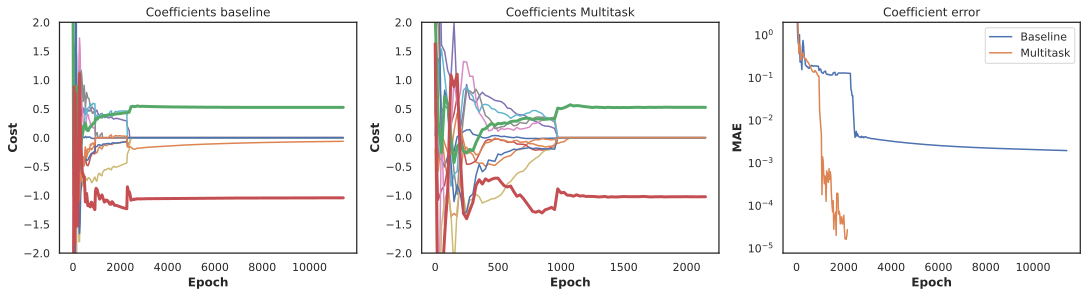

In [16]:
fig, axes = plt.subplots(ncols=3, constrained_layout=True, figsize=(15, 4))

ax = axes[0]
ax.plot(data_bl.df.index, data_bl.df[keys['coeffs']])
ax.plot(data_bl.df.index, data_bl.df[keys['coeffs'][2]], lw=3)
ax.plot(data_bl.df.index, data_bl.df[keys['coeffs'][5]], lw=3)
ax.set_ylim([-2, 2])
ax.set_title('Coefficients baseline')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
#ax.set_xlim([0, 8000])

ax = axes[1]
ax.plot(data_mt.df.index, data_mt.df[keys['coeffs']])
ax.plot(data_mt.df.index, data_mt.df[keys['coeffs'][2]], lw=3)
ax.plot(data_mt.df.index, data_mt.df[keys['coeffs'][5]], lw=3)
ax.set_ylim([-2, 2])
ax.set_title('Coefficients Multitask')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
#ax.set_xlim([0, 8000])

ax = axes[2]
true_coeffs = np.zeros(len(keys['unscaled_coeffs']))
true_coeffs[2] = 0.1
true_coeffs[5] = -1

ax.semilogy(data_bl.df.index, np.mean(np.abs(data_bl.df[keys['unscaled_coeffs']] - true_coeffs), axis=1), label='Baseline')
ax.semilogy(data_mt.df.index, np.mean(np.abs(data_mt.df[keys['unscaled_coeffs']] - true_coeffs), axis=1), label='Multitask')
ax.set_ylim([-5, 2])
ax.legend()
ax.set_title('Coefficient error')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('MAE', weight='bold')

fig.show()

# KdV

In [57]:
# Making data
x = np.linspace(-5, 5, 100)
t = np.linspace(0.0, 1.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

dataset = Dataset(DoubleSoliton, c=[5.0, 2.0], x0=[-3.0, -1.0])

X, y = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=2000, noise=0.1, normalize=False, random=True)
X, y = X.to(device), y.to(device)

In [58]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

In [59]:
sparsity_scheduler = TrainTestPeriodic(patience=8, delta=1e-5, periodicity=50)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True, lr=2e-3) # Defining optimizer

In [60]:
train_multitask(model, X, y, optimizer, sparsity_scheduler, write_iterations=25, log_dir='runs/kdv/testing_multitask/', max_iterations=15000, delta=1e-3, patience=8) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       4625     30.83%             436s   -1.28e+01   4.22e-03   3.22e-05   2.51e+00 Algorithm converged. Stopping training.


In [61]:
network = NN(2, [30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=2, diff_order=3) # Library function
estimator = Threshold(0.1) # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

In [62]:
sparsity_scheduler = TrainTestPeriodic(patience=8, delta=1e-5, periodicity=50)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True, lr=2e-3) # Defining optimizer

In [63]:
train(model, X, y, optimizer, sparsity_scheduler, write_iterations=25, log_dir='runs/kdv/testing_normal/', max_iterations=15000, delta=1e-3, patience=8) # Running

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       3375     22.50%             489s   4.20e-03   4.14e-03   5.87e-05   2.52e+00 Algorithm converged. Stopping training.


## Quick analysis

In [69]:
from phimal_utilities.analysis import Results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='white')

%config InlineBackend.figure_format = 'svg'

In [70]:
data_mt = Results('runs/kdv/testing_multitask/')
data_bl = Results('runs/kdv/testing_normal/')

keys = data_mt.keys

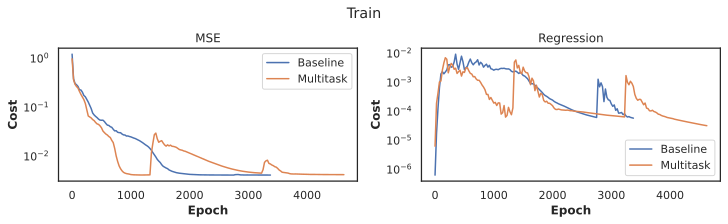

In [71]:
fig, axes = plt.subplots(figsize=(10, 3), constrained_layout=True, ncols=2)

ax = axes[0]
ax.semilogy(data_bl.df.index, data_bl.df[keys['mse']], label='Baseline')
ax.semilogy(data_mt.df.index, data_mt.df[keys['mse']], label='Multitask')
ax.set_title('MSE')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
ax.legend()
#ax.set_xlim([0, 8000])


ax = axes[1]
ax.semilogy(data_bl.df.index, data_bl.df[keys['reg']], label='Baseline')
ax.semilogy(data_mt.df.index, data_mt.df[keys['reg']], label='Multitask')
ax.set_title('Regression')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
ax.legend()
#ax.set_xlim([0, 8000])

fig.suptitle('Train')
fig.show()

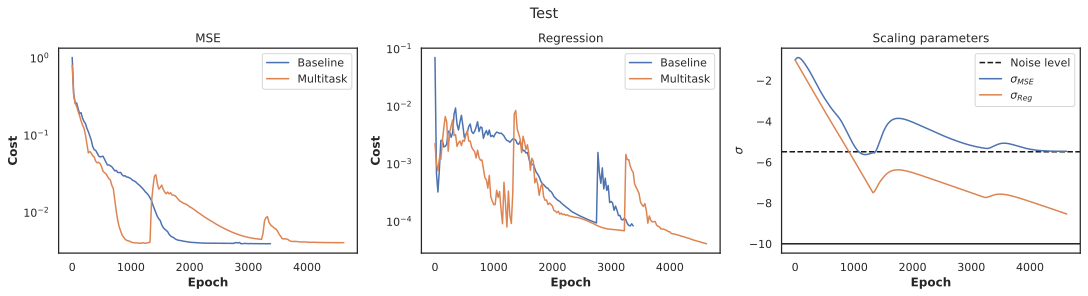

In [90]:
fig, axes = plt.subplots(figsize=(15, 4), constrained_layout=True, ncols=3)

ax = axes[0]
ax.semilogy(data_bl.df.index, data_bl.df['remaining_MSE_test'], label='Baseline')
ax.semilogy(data_mt.df.index, data_mt.df['remaining_MSE_test'], label='Multitask')
ax.set_title('MSE')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
ax.legend()
#ax.set_xlim([0, 8000])


ax = axes[1]
ax.semilogy(data_bl.df.index, data_bl.df['remaining_Reg_test'], label='Baseline')
ax.semilogy(data_mt.df.index, data_mt.df['remaining_Reg_test'], label='Multitask')
ax.set_title('Regression')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
ax.legend()
#ax.set_xlim([0, 8000])

ax = axes[2]
ax.axhline(-10, linestyle='-', color='k')
ax.axhline(np.log((0.1 * torch.std(y).numpy())**2), linestyle='--', color='k', label='Noise level')
ax.plot(data_mt.df.index, data_mt.df['remaining_s_val_0'], label=r'$\sigma_{MSE}$')
ax.plot(data_mt.df.index, data_mt.df['remaining_s_val_1'], label=r'$\sigma_{Reg}$')

ax.set_title('Scaling parameters')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel(r'$\sigma$', weight='bold')
ax.legend()

fig.suptitle('Test')
fig.show()

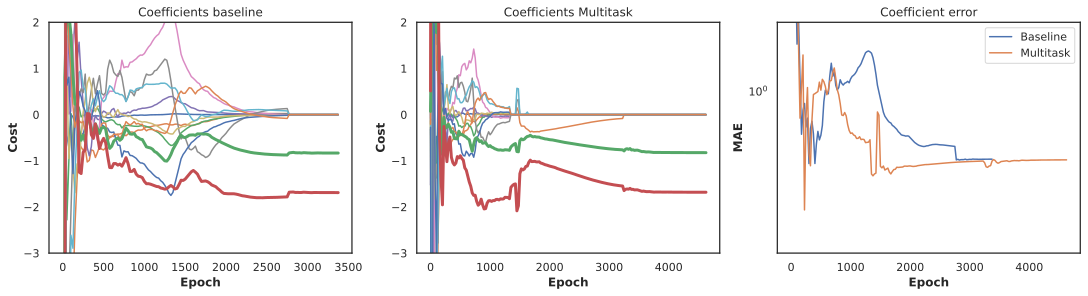

In [73]:
fig, axes = plt.subplots(ncols=3, constrained_layout=True, figsize=(15, 4))

ax = axes[0]
ax.plot(data_bl.df.index, data_bl.df[keys['coeffs']])
ax.plot(data_bl.df.index, data_bl.df[keys['coeffs'][3]], lw=3)
ax.plot(data_bl.df.index, data_bl.df[keys['coeffs'][5]], lw=3)
ax.set_ylim([-3, 2])
ax.set_title('Coefficients baseline')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
#ax.set_xlim([0, 8000])

ax = axes[1]
ax.plot(data_mt.df.index, data_mt.df[keys['coeffs']])
ax.plot(data_mt.df.index, data_mt.df[keys['coeffs'][3]], lw=3)
ax.plot(data_mt.df.index, data_mt.df[keys['coeffs'][5]], lw=3)
ax.set_ylim([-3, 2])
ax.set_title('Coefficients Multitask')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('Cost', weight='bold')
#ax.set_xlim([0, 8000])

ax = axes[2]
true_coeffs = np.zeros(len(keys['unscaled_coeffs']))
true_coeffs[2] = 0.1
true_coeffs[5] = -1

ax.semilogy(data_bl.df.index, np.mean(np.abs(data_bl.df[keys['unscaled_coeffs']] - true_coeffs), axis=1), label='Baseline')
ax.semilogy(data_mt.df.index, np.mean(np.abs(data_mt.df[keys['unscaled_coeffs']] - true_coeffs), axis=1), label='Multitask')
ax.set_ylim([-5, 2])
ax.legend()
ax.set_title('Coefficient error')
ax.set_xlabel('Epoch', weight='bold')
ax.set_ylabel('MAE', weight='bold')

fig.show()

Why does the MSE jump so much?